# RFF+SVS preliminary tests

**Not implemented**
* GPU usage (just set device to conda).
* Optimal initilization of bandwidths.
*

**Architecture**

![Architecture](../figures/nn2.png)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

In [2]:
plt.style.use('../figures/rffsvs.mplstyle')

In [3]:
torch.manual_seed(42)
np.random.seed(42)

## Architecture

### Hadamard Layer

In [4]:
class HadamardLayer(nn.Module):

    # TODO: consistent broadcasting, bandwidth initialization, named tensors
    def __init__(self, in_features):
        """Hadamard layer of bandwidths with constant (val = 0)
        initialization.
        """
        super(HadamardLayer, self).__init__()
        self.in_features = in_features
        self.bandwidths = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()
        
    def forward(self, x):
        return self.bandwidths * x
    
    def reset_parameters(self):
        nn.init.constant_(self.bandwidths, 0)
    
    def __repr__(self):
        return(f"HadamardLayer(in_features={self.in_features})")

### RFF Layer

In [5]:
class RFFLayer(nn.Module):
    
    # TODO: parameter tracking (is bw tracked?), named tensors
    def __init__(self, in_features, out_features):
        """Random Fourier Features layer."""
        super(RFFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self._normal_sample = torch.randn(self.in_features, self.out_features)
        self._unif_sample = torch.rand(self.out_features)*2*np.pi
    
    def forward(self, x):
        norm = torch.tensor(2.0/self.out_features) # normalizing factor for LLN.
        output = torch.sqrt(norm)*torch.cos(x @ self._normal_sample + self._unif_sample)
        return output     
    
    def __repr__(self):
        return(f"RFFLayer(in_features={self.in_features}, out_features={self.out_features})")
        

### RFF Net

In [6]:
class RFFNet(nn.Module):

    # TODO: final layer can be set to a different architecture.
    def __init__(self, in_features, R):
        """Neural network specification."""
        super(RFFNet, self).__init__()
        self.rff_net = nn.Sequential(
                HadamardLayer(in_features),
                RFFLayer(in_features, R),
                nn.Linear(R, 1, bias=False)
        )
        
    def forward(self, x):
        output = self.rff_net(x)
        return output
    

## Synthetic Data

In [7]:
def data_synthesizer(sample_size, n_features, n_relevant_features,
                    param_range=np.array([-5, 5])):
    X = torch.rand(sample_size, n_features)
    true_beta = torch.zeros(n_features)
    relevant_feat = np.random.choice(n_features, n_relevant_features, replace=False) # sample indexes of relevant features
    true_beta[relevant_feat] = param_range[0] + param_range.ptp() * torch.rand(n_relevant_features) # set relevant features to param_range
    y = X @ true_beta.unsqueeze_(-1) 
    return X, y, true_beta

In [8]:
n_samples = 1000

In [9]:
n_features = 100

In [10]:
n_relevant_features = 5

In [11]:
X, y, true_beta = data_synthesizer(n_samples, n_features=n_features, n_relevant_features=n_relevant_features)

## Training

### Training/Test split

In [12]:
training_frac = 0.8

In [13]:
training_size = int(training_frac*n_samples)

In [14]:
shuffled_indices = torch.randperm(n_samples)
train_indices, val_indices = shuffled_indices[:-training_size], shuffled_indices[-training_size:]

In [15]:
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]

### Model specification

In [16]:
R = 300

In [17]:
rff_model = RFFNet(n_features, R)

In [18]:
rff_model

RFFNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=100)
    (1): RFFLayer(in_features=100, out_features=300)
    (2): Linear(in_features=300, out_features=1, bias=False)
  )
)

**Parameters**

In [19]:
list(rff_model.parameters())

[Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[-4.7754e-03,  3.6703e-02,  3.0474e-02,  3.2455e-02, -2.7643e-02,
           1.9281e-03, -3.0414e-02, -1.3536e-02, -1.2820e-02, -3.4188e-02,
          -5.0428e-02,  1.0587e-02, -1.1623e-02,  3.6382e-02,  1.2496e-02,
           5.5522e-02, -2.5506e-02, -2.2035e-02, -5.3721e-02, -1.7031e-02,
          -4.4540e-03,  1.3550e-02,  4.0048e-02, -2.2509e-02,  5.3932e-02,
          -5.1595e-02,  1.4592e-02,  1.2856e-02, -3.5140e-02,  4.8493e-02,
          -8.7512e-03,  1.9612e-02,  

In [20]:
optim = torch.optim.SGD(rff_model.parameters(), lr=1e-3) # plain SGD, no momentum

In [21]:
loss_fn = torch.nn.MSELoss() 

In [22]:
train_loss_history = []
val_loss_history = []

In [23]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, y_train, X_val, y_val):
    for epoch in range(1, n_epochs+1):
        y_train_pred = model(X_train)
        loss_train = loss_fn(y_train_pred, y_train)
        y_val_pred = model(X_val)
        
        loss_val = loss_fn(y_val_pred, y_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        train_loss_history.append(loss_train.item())
        val_loss_history.append(loss_val.item())
        
        if epoch == 1 or epoch % 2000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.7f},"
                  f" Validation loss {loss_val.item():.7f}")
        

In [24]:
n_epochs = 2*10**5

In [25]:
training_loop(n_epochs=n_epochs,
              model=rff_model,
             optimizer=optim,
             loss_fn=loss_fn,
              X_train=X_train, 
              y_train=y_train, 
              X_val=X_val, 
              y_val=y_val)

Epoch 1, Training loss 4.5873098, Validation loss 4.4971509
Epoch 2000, Training loss 3.7683673, Validation loss 3.7811368
Epoch 4000, Training loss 3.4674654, Validation loss 3.4767389
Epoch 6000, Training loss 2.1290927, Validation loss 2.1035891
Epoch 8000, Training loss 1.4920677, Validation loss 1.4797057
Epoch 10000, Training loss 0.9901964, Validation loss 1.0105039
Epoch 12000, Training loss 0.6880594, Validation loss 0.7253187
Epoch 14000, Training loss 0.5359738, Validation loss 0.5763924
Epoch 16000, Training loss 0.4431602, Validation loss 0.4809535
Epoch 18000, Training loss 0.3702713, Validation loss 0.4030721
Epoch 20000, Training loss 0.3101483, Validation loss 0.3377735
Epoch 22000, Training loss 0.2628822, Validation loss 0.2865202
Epoch 24000, Training loss 0.2268021, Validation loss 0.2479777
Epoch 26000, Training loss 0.1990574, Validation loss 0.2190369
Epoch 28000, Training loss 0.1770315, Validation loss 0.1966816
Epoch 30000, Training loss 0.1588139, Validation

## Visualization

### Training

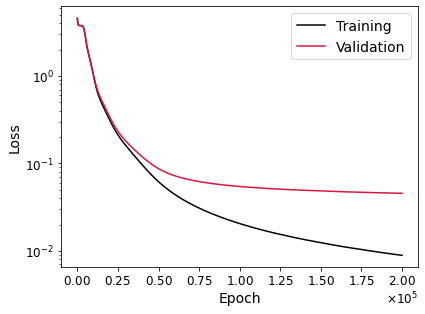

In [26]:
plt.plot(train_loss_history, color='k', label='Training')
plt.plot(val_loss_history, color='crimson', label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.yscale('log')
plt.show()

### Bandwidths

In [27]:
params = list(rff_model.parameters())

In [28]:
bandwidths = params[0].data.numpy()

In [29]:
true_beta_array = true_beta.squeeze(1).numpy()

In [30]:
bins = np.linspace(bandwidths.min(), bandwidths.max(), 20)

In [31]:
n_features, n_relevant_features, R

(100, 5, 300)

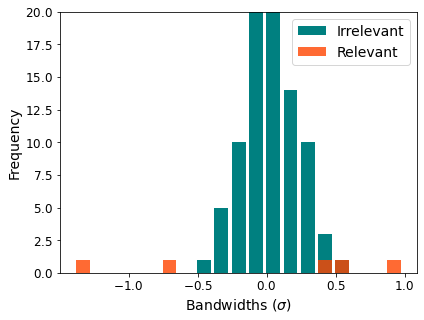

In [32]:
plt.hist(bandwidths[true_beta_array == 0], bins=bins, rwidth=0.8, color='teal', label="Irrelevant")
plt.hist(bandwidths[true_beta_array != 0], bins=bins, rwidth=0.8, alpha=0.8, color='orangered', label="Relevant", zorder=20)
ax = plt.gca()
ax.set_xlabel("Bandwidths ($\sigma$)")
ax.set_ylabel("Frequency")
plt.legend(loc='best')
plt.ylim(0, 20)
plt.show()

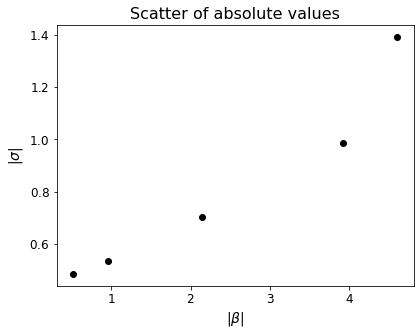

In [33]:
plt.plot(np.abs(true_beta_array[true_beta_array !=0]), np.abs(bandwidths[true_beta_array != 0]), 'o', color='k')
ax = plt.gca()
ax.set_ylabel("$|\sigma|$")
ax.set_xlabel(r"$|\beta|$")
ax.set_title(r'Scatter of absolute values')
plt.show()